In [74]:
# Import libraries
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to datasets
train_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\train"
valid_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\valid"
test_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\test"
model_save_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\best_model_vgg.keras"

In [75]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [76]:
# Rescaling for validation and testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 4921 images belonging to 5 classes.
Found 542 images belonging to 5 classes.
Found 559 images belonging to 5 classes.


In [77]:
# Load pre-trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [78]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [79]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True)

In [80]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, model_checkpoint]
)

c:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.1994 - loss: 1.7528 - val_accuracy: 0.2454 - val_loss: 1.5949
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.2423 - loss: 1.6692 - val_accuracy: 0.2657 - val_loss: 1.5806
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.2628 - loss: 1.6342 - val_accuracy: 0.2970 - val_loss: 1.5689
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.2711 - loss: 1.6130 - val_accuracy: 0.3284 - val_loss: 1.5590
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.2884 - loss: 1.5874 - val_accuracy: 0.3376 - val_loss: 1.5492
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.3107 - loss: 1.5502 - val_accuracy: 0.3450 - val_loss: 1.5426
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.3273 - loss: 1.5254 - val_accuracy: 0.3487 - val_loss: 1.5362
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.3495 - loss: 1.4990 - val_accu

In [81]:
# Fine-tuning: Unfreeze top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
# Continue training with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.5323 - loss: 1.1922 - val_accuracy: 0.4317 - val_loss: 1.3968
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 542s 4s/step - accuracy: 0.6406 - loss: 0.9372 - val_accuracy: 0.5129 - val_loss: 1.2793
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 541s 4s/step - accuracy: 0.6923 - loss: 0.7853 - val_accuracy: 0.5627 - val_loss: 1.1377
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.7331 - loss: 0.7148 - val_accuracy: 0.5978 - val_loss: 1.0693
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.7525 - loss: 0.6554 - val_accuracy: 0.6033 - val_loss: 1.0664
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 523s 3s/step - accuracy: 0.7892 - loss: 0.5940 - val_accuracy: 0.6089 - val_loss: 1.0298
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 523s 3s/step - accuracy: 0.7907 - loss: 0.5830 - val_accuracy: 0.6255 - val_loss: 1.1512
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 525s 3s/step - accuracy: 0.8100 - loss: 0.5397 - val_accu

In [83]:
model.save(r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\final_model_vgg.h5")

In [84]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7058 - loss: 0.7876
Test Accuracy: 61.36%
Test Loss: 0.9840


In [85]:
# Classification Report and Confusion Matrix
test_preds = model.predict(test_generator)
test_pred_classes = np.argmax(test_preds, axis=1)
true_classes = test_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Classification Report
print(classification_report(true_classes, test_pred_classes, target_names=class_labels))

18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step
              precision    recall  f1-score   support

  Botol Kaca       0.72      0.81      0.76       134
      Kaleng       0.71      0.78      0.74       112
      Kardus       0.55      0.61      0.58        61
      Kertas       0.50      0.32      0.39       126
     Plastik       0.51      0.56      0.54       126

    accuracy                           0.61       559
   macro avg       0.60      0.61      0.60       559
weighted avg       0.60      0.61      0.60       559



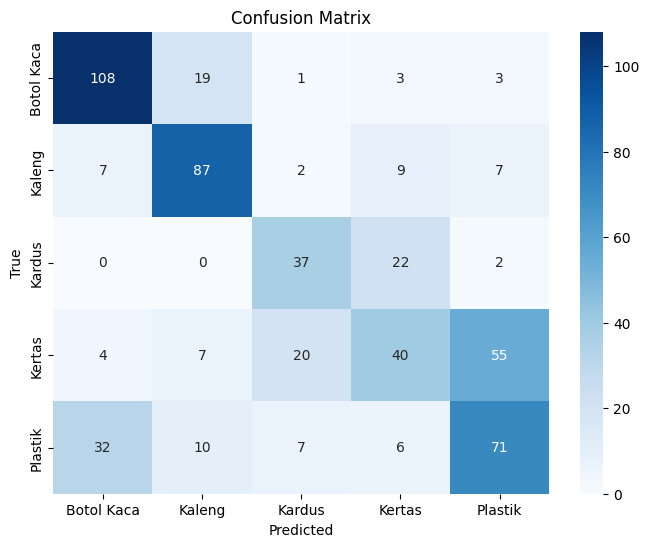

In [86]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

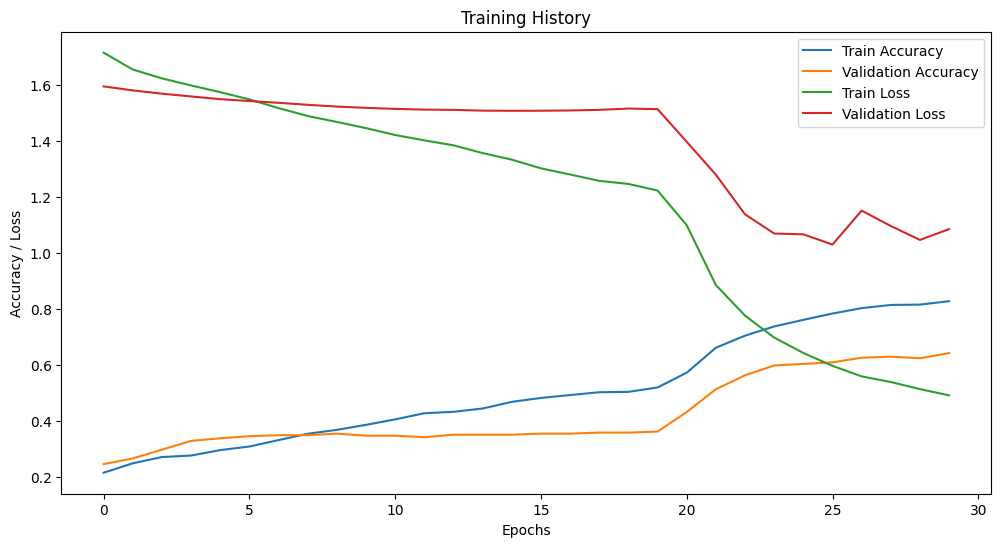

In [87]:
# Visualization of training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


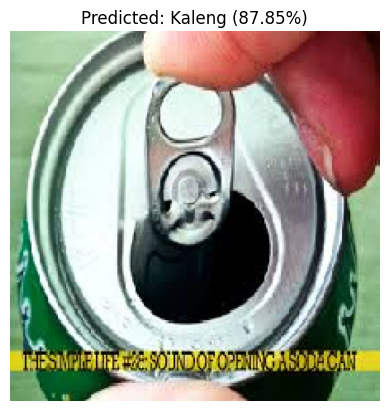

In [88]:
# Predict a single image
def predict_image(image_path, model, class_labels):
    img = load_img(image_path, target_size=(224, 224))  # Resize image
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch
    
    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()

# Example: Predict a single image
test_image_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\test\Kaleng\R_2094.jpg"
predict_image(test_image_path, model, class_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


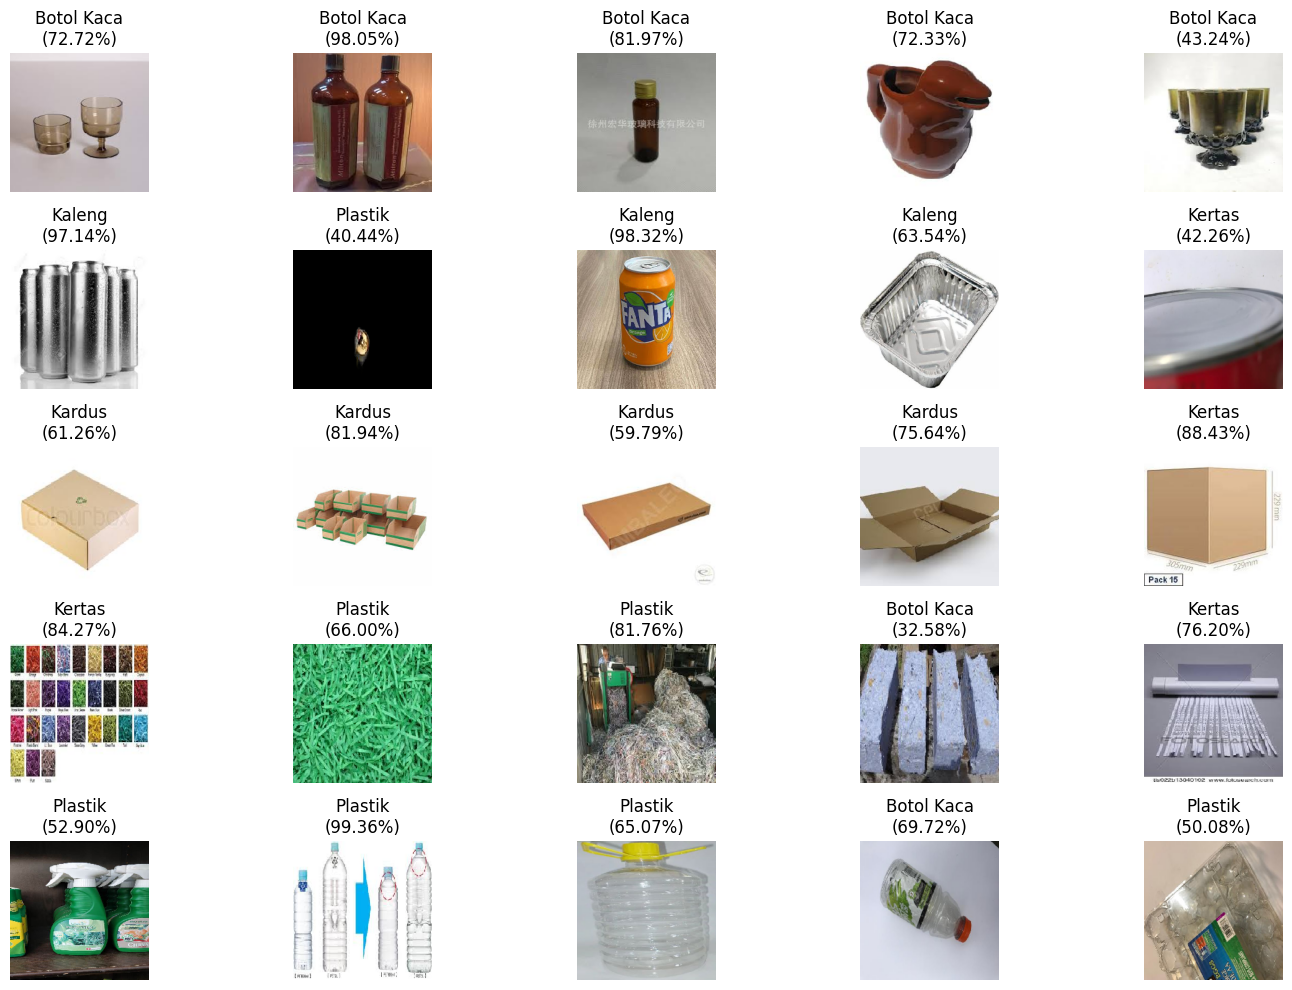

In [89]:
# Predict batch of images
def predict_batch_images(test_path, model, class_labels, num_images=5):
    test_categories = os.listdir(test_path)
    plt.figure(figsize=(15, 10))
    
    count = 0
    for category in test_categories:
        category_path = os.path.join(test_path, category)
        images = os.listdir(category_path)[:num_images]
        
        for image_name in images:
            img_path = os.path.join(category_path, image_name)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Predict
            prediction = model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction) * 100
            
            # Display the image and prediction
            plt.subplot(len(test_categories), num_images, count + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{predicted_class}\n({confidence:.2f}%)")
            count += 1
    plt.tight_layout()
    plt.show()

# Example: Predict a batch of images
predict_batch_images(test_path, model, class_labels, num_images=5)
